분석 목표

1. 100k_a.csv : 시청자-스트리머 네트워크 분석
 - 시청자-스트리머 네트워크를 구성하고 중심성 분석 및 시각화
 - 노드: 시청자 / 스트리머
 - 엣지: 스트리머를 시청한 기록
 - 분석: 중심성(Degree, Betweenness), 커뮤니티 탐지(Louvain), 네트워크 시각화(PyVis)

 2. sodapoppin.csv : 채팅 활동 분석
 - 채팅 수, 시청자 수, 발화량 분포
 - 채팅 빈도 기준 핵심 참여자 분석

3. xqcow.csv : 채팅 활동 분석
 - sodapoppin과 동일 방식으로 비교 분석 가능
 - 평균 채팅량, Peak 시간대 분석

In [1]:
# 필요한 세 파일 다시 로드
import pandas as pd

extract_dir = './data'

# 1.
df_relations = pd.read_csv(f'{extract_dir}/Twitch Live-Streaming Interactions Sample Dataset/100k_a.csv', header=None)
df_relations.drop(columns=0, inplace=True)  # 첫 열 제거
df_relations.columns = ["viewer_id", "streamer_id", "watch_time", "watch_date"]

# 2.
df_sodapoppin = pd.read_csv(f"{extract_dir}/Twitch chat dataset Xqcow, Sodapoppin/sodapoppin.csv")

# 3.
df_xqcow = pd.read_csv(f"{extract_dir}/Twitch chat dataset Xqcow, Sodapoppin/xqcow.csv")

# 각 데이터프레임 미리보기
df_relations.head(), df_sodapoppin.head(), df_xqcow.head()


(     viewer_id streamer_id  watch_time  watch_date
 0  33842865744    mithrain         154         156
 1  33846768288       alptv         166         169
 2  33886469056    mithrain         587         588
 3  33887624992        wtcn         589         591
 4  33890145056   jrokezftw         591         594,
       Message_Datetime        Name  Moderator  VIP  Subscriber  \
 0  2021-12-18 01:23:37      Mhepps          0    0           0   
 1  2021-12-18 01:23:44      Pispet          0    0           1   
 2  2021-12-18 01:23:50  Maarionete          0    0           0   
 3  2021-12-18 01:23:59     justTNK          0    0           1   
 4  2021-12-18 01:24:05  Maarionete          0    0           0   
 
    Is_First_Message  Message_len  qtd_msgs_15_secs  \
 0                 0           42               1.0   
 1                 0           53               1.0   
 2                 0           10               1.0   
 3                 0           24               1.0   
 4      

1. 100k_a.csv – 시청자–스트리머 관계 로그

이 파일은 시청자와 스트리머 간의 연결을 나타냅니다.

| 컬럼명           | 설명                                   |
| ------------- | ------------------------------------ |
| `user_id`     | 시청자 고유 ID                            |
| `streamer_id` | 스트리머 고유 ID                           |
| `watch_time`  | 해당 시청자가 스트리머의 방송을 시청한 시간 (초 또는 분 단위) |
| `watch_date`  | 시청 날짜 또는 타임스탬프 (존재 시)                |

활용 목적: 이 데이터를 바탕으로 양방향 네트워크(시청자 ↔ 스트리머)를 구성할 수 있습니다.

2. sodapoppin.csv – 특정 스트리머의 채팅 로그

| 컬럼명         | 설명                   |
| ----------- | -------------------- |
| `timestamp` | 채팅이 기록된 시간           |
| `user_id`   | 채팅을 입력한 시청자 ID       |
| `message`   | 채팅 내용 (text)         |
| `channel`   | 채널명 (고정: sodapoppin) |

 활용 목적:

채팅 참여도 분석 (유저별, 시간별)

텍스트 기반 감정 분석, 워드 클라우드 등도 가능

3. xqcow.csv – 또 다른 스트리머의 채팅 로그

구성은 sodapoppin.csv와 동일합니다. 비교 분석에 적합합니다.

In [28]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템별 폰트 경로 설정
if platform.system() == 'Windows':
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 말랑체 또는 나눔고딕 등
elif platform.system() == 'Darwin':  # MacOS
    font_path = "/System/Library/Fonts/AppleGothic.ttf"
else:  # Linux (예: Colab)
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


노드 수: 902616, 엣지 수: 739991
Top 10 중심 노드 (유저/스트리머): ['luke4316live', 'armatvhs', 'yogscast', 'igromania', 'giannielee', 'trustedfate', 'imbadon123', 'sparktv_mtg', 'gantver1', 'speedgaming']


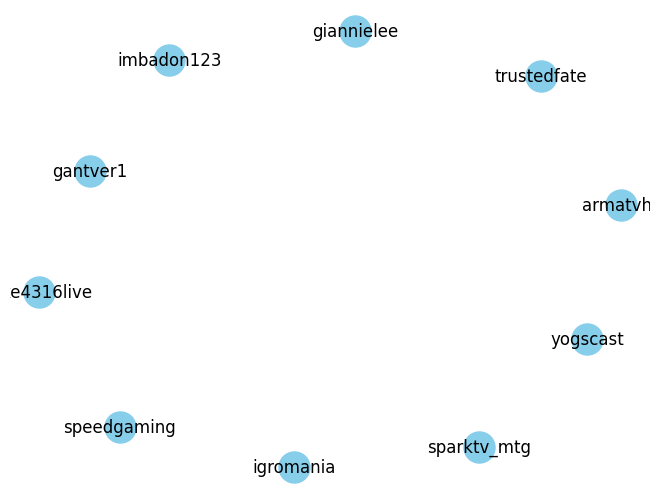

In [30]:
# 1. 시청자-스트리머 네트워크 분석

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = df_relations

# 2. 네트워크 그래프 생성
# 시청자-스트리머 간 관계 그래프 생성
G = nx.Graph()
edges = list(zip(df_relations["viewer_id"], df_relations["streamer_id"]))
G.add_edges_from(edges)

# 3. 기본 정보 출력
print(f"노드 수: {G.number_of_nodes()}, 엣지 수: {G.number_of_edges()}")

# 4. 중심성 계산
degree_centrality = nx.degree_centrality(G)
top_10 = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_nodes = [node for node, _ in top_10]
print("Top 10 중심 노드 (유저/스트리머):", top_nodes)

# 5. 시각화 (그래프)
sample_nodes = list(dict(top_10).keys())
subgraph = G.subgraph(sample_nodes)
nx.draw(subgraph, with_labels=True, node_size=500, node_color="skyblue")
plt.show()


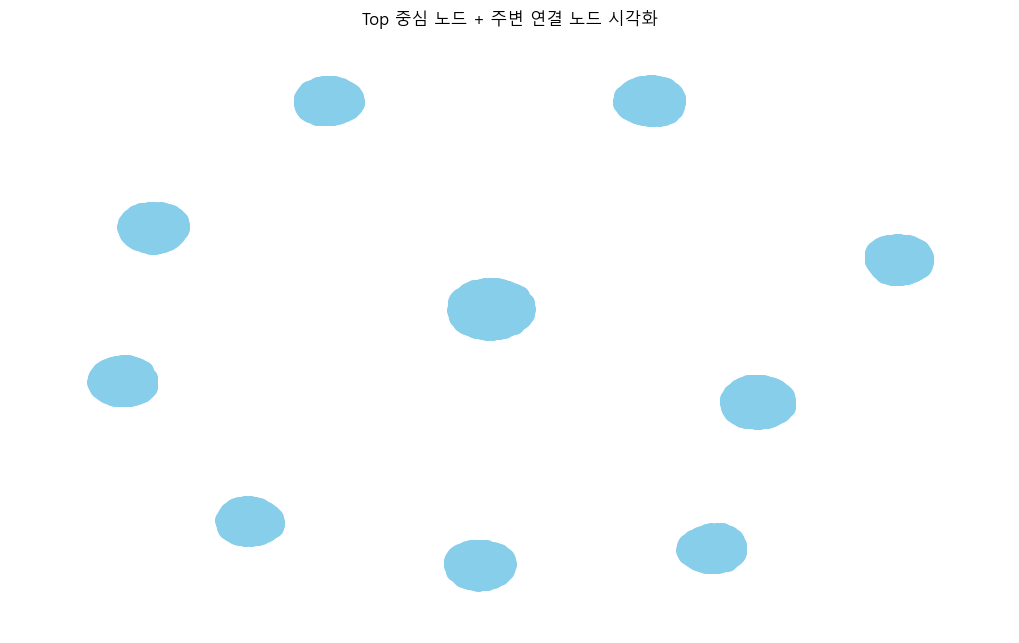

In [36]:
# 1. Top 노드들이 서로 연결된 노드 포함하여 서브그래프 확장

# 중심성 상위 노드 (예: Top 10)
top_nodes = [node for node, _ in top_10]

# 중심 노드 + 이웃까지 포함한 하위 그래프 생성
neighbors = set()
for node in top_nodes:
    neighbors.update(G.neighbors(node))
sub_nodes = list(set(top_nodes) | neighbors)

subgraph = G.subgraph(sub_nodes)

# 시각화
plt.figure(figsize=(10, 6))
nx.draw(subgraph, with_labels=False, node_size=200, node_color="skyblue")
plt.title("Top 중심 노드 + 주변 연결 노드 시각화")
plt.show()


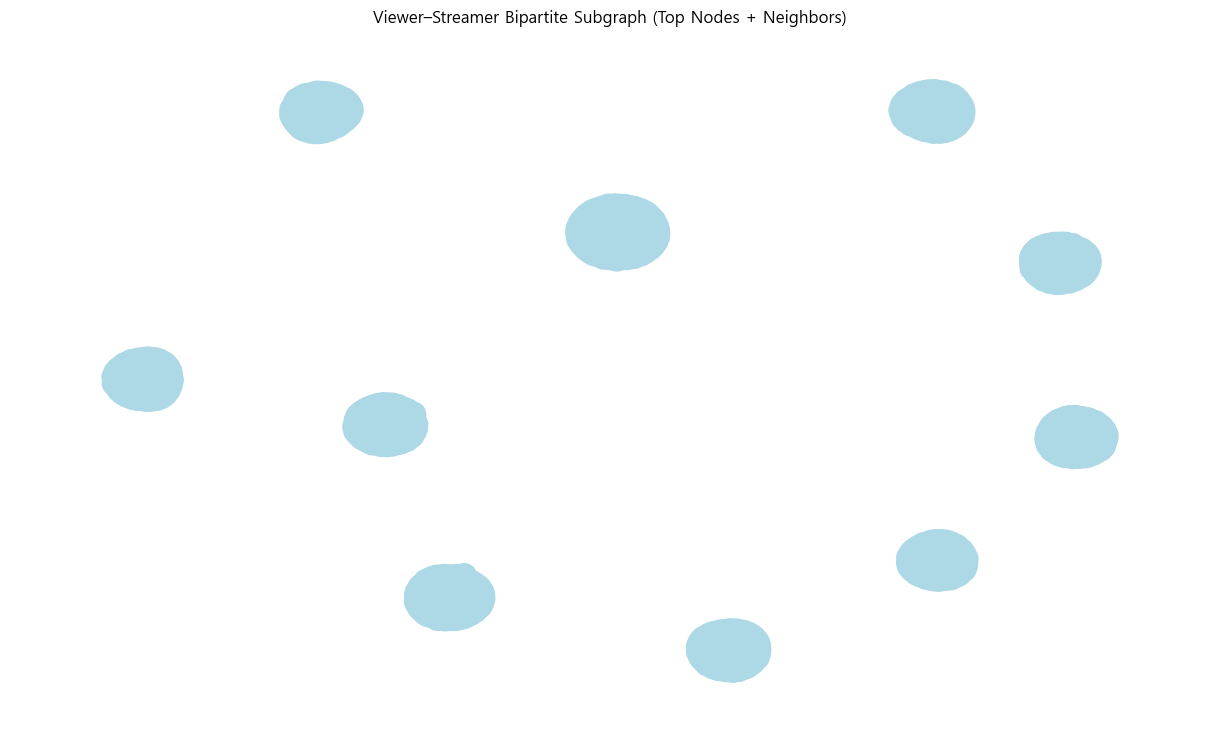

In [35]:
# 2. 이중 모드(Bipartite) 그래프 시각화로 전환

from networkx.algorithms import bipartite

# 시청자, 스트리머 집합 분리
viewers = df_relations["viewer_id"].unique()
streamers = df_relations["streamer_id"].unique()

# 이중 모드 태그 추가
node_colors = []
for node in subgraph.nodes():
    node_colors.append('lightcoral' if node in streamers else 'lightblue')

# 시각화
plt.figure(figsize=(12, 7))
nx.draw(subgraph, node_color=node_colors, with_labels=False, node_size=300)
plt.title("Viewer–Streamer Bipartite Subgraph (Top Nodes + Neighbors)")
plt.show()


In [45]:
# PyVis 기반 시각화로 전환

from pyvis.network import Network
import networkx as nx
import pandas as pd

# 데이터 로드
# df_relations

# 전체 그래프 생성
G = nx.Graph()
edges = list(zip(df_relations["viewer_id"], df_relations["streamer_id"]))
G.add_edges_from(edges)

# 중심성 기준 상위 노드 선택
degree = nx.degree_centrality(G)
top_10 = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]
top_nodes = [node for node, _ in top_10]

# 중심 노드 + 이웃 노드 포함한 서브그래프
neighbors = set()
for node in top_nodes:
    neighbors.update(G.neighbors(node))
sub_nodes = list(set(top_nodes) | neighbors)
subgraph = G.subgraph(sub_nodes)

# PyVis 네트워크 생성
net = Network(height="750px", width="100%", bgcolor="#1e1e1e", font_color="white")
net.from_nx(subgraph)

# 노드 그룹 색상 분리 (스트리머 vs 시청자)
streamer_ids = set(df_relations["streamer_id"].unique())
for node in net.nodes:
    if node["id"] in streamer_ids:
        node["color"] = "orange"
        node["title"] = f"스트리머: {node['id']}"
    else:
        node["color"] = "skyblue"
        node["title"] = f"시청자: {node['id']}"

# 안전하게 HTML 저장
html_path = "twitch_network.html"
net.write_html(html_path)

# 브라우저로 직접 열기 (로컬 환경에서만 작동)
import webbrowser
webbrowser.open(html_path)



1. twitch_network.html : 관계의 기본 구조 확인
* 시각화 구성
 - 중심성(degree centrality) 기준으로 상위 10개의 핵심 노드를 선정
 - 해당 노드와 직접 연결된 이웃 노드들로 부분 그래프(subgraph)를 구성
 - 시각화는 기본적인 관계 구조만 표현 (엣지 weight, 색상, 커뮤니티 없음)

* 해석
 - 어떤 시청자가 어떤 스트리머와 연결되어 있는지를 단순히 보여줌
 - 영향력 있는 중심 노드가 노드 수 기준으로 얼마나 연결되어 있는지 파악 가능
 - 노드들은 파란색 계열이며, 특별한 그룹 분류는 없음
 - 노드 클릭 시 ID 확인 가능

In [54]:
# 커뮤니티 탐색 (Label Propagation)
from networkx.algorithms.community import label_propagation_communities
communities = list(label_propagation_communities(subgraph))
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i

# PyVis 시각화 구성
net = Network(height="750px", width="100%", bgcolor="#1e1e1e", font_color="white")
net.from_nx(subgraph)

# 스트리머 ID 목록
streamer_ids = set(df_relations["streamer_id"].unique())

# 노드 스타일 지정
for node in net.nodes:
    node_id = node["id"]
    node["color"] = f"hsl({(community_map[node_id]*47)%360}, 70%, 60%)"  # 커뮤니티 기반 색상
    if node_id in streamer_ids:
        node["shape"] = "box"
        node["title"] = f"Streamer: {node_id}"
    else:
        node["shape"] = "dot"
        node["title"] = f"Viewer: {node_id}"

# G 대신 subgraph를 기준으로 조회
for edge in net.edges:
    try:
        edge["value"] = subgraph[edge["from"]][edge["to"]].get("weight", 1)
        edge["title"] = f"Watch Time: {edge['value']}"
    except KeyError:
        edge["value"] = 1
        edge["title"] = "Watch Time: N/A"

# HTML 저장
pyvis_path = "twitch_network_weighted_clusters.html"
net.write_html(pyvis_path)

# 브라우저로 직접 열기 (로컬 환경에서만 작동)
import webbrowser
webbrowser.open(pyvis_path)

True

2. twitch_network_weighted_clusters.html : 실제 상호작용 강도, 커뮤니티 중심 탐색, 전략적 인사이트
* 시각화 구성 (확장된 버전)
 - 동일한 중심 노드를 기반으로 subgraph 구성
 - watch_time (시청 시간)을 엣지의 두께(value)로 표현
→ 두꺼운 선 = 시청 시간이 길다
 - 커뮤니티 탐지 알고리즘(Label Propagation)을 활용해 각 노드를 그룹으로 분류
→ 노드 색상에 그룹 반영
 - 스트리머 노드는 box 모양, 시청자는 dot 모양으로 구분
 - 각 노드와 엣지를 마우스로 hover 시 ID와 시청 시간 등 정보 표시

* 해석
 - 시청자와 스트리머 사이의 관계 강도를 파악 가능
→ 시청 시간이 긴 경우 더 굵은 선으로 연결됨
 - 시청자 그룹 간 커뮤니티 구조를 시각적으로 확인 가능
→ 예: 특정 스트리머에 집중된 시청자 그룹
 - 스트리머와 시청자를 시각적으로 명확히 구분
→ 박스 = 스트리머, 원형 = 시청자

비교 요약

| 항목    | `twitch_network.html` | `twitch_network_weighted_clusters.html` |
| ----- | --------------------- | --------------------------------------- |
| 노드 수  | 중심 노드 + 이웃            | 동일                                      |
| 엣지 굵기 | 고정                    | **watch\_time 기반**                      |
| 노드 색  | 단일 색상                 | **커뮤니티 기반 색상**                          |
| 노드 모양 | 동일                    | **스트리머/시청자 구분**                         |
| 정보 표시 | 기본                    | **watch\_time, 역할 등 포함**                |
| 목적    | 단순 관계 확인              | **관계 강도 + 구조 분석**                       |
